<a href="https://colab.research.google.com/github/sophie-myk/AIFFEL_quest_cr/blob/main/Exploration/Quest02/news_summarize250411.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🗞️ 프로젝트: 뉴스기사 요약해보기 🗞️**

In [ ]:
pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=f1f98a2b41fb16d56f0f3aee0ff36366f2220137277e21e94832d19e9c8cc622
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [ ]:
#필요한 모듈 import하기
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.18.0
2.2.2
1.2.0


In [ ]:
#필요한 모듈 import하기
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[뉴스 데이터 링크](https://github.com/sunnysai12345/News_Summary)
## Step 1. 데이터 수집하기

In [ ]:
# 뉴스 데이터 가져오기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
# 데이터 확인 및 출력
data.sample(10)

,headlines,text
69140,BJP government renamed 23 schemes launched by ...,The Congress on Wednesday alleged that the BJP...
62471,17-year-old footballer dies after cardiac arre...,Belgian football club Royal Antwerp's 17-year-...
67730,Products not using AI will die a natural death...,"Manish Singhal, the Co-founder of pi Ventures,..."
63063,Fake News named word of the year by Collins Di...,Collins Dictionary has named 'Fake News' word ...
58818,Sachin's number 10 jersey unofficially retired...,The BCCI has decided to retire Sachin Tendulka...
78700,"Apple will build 3 big, beautiful plants in US...",US President Donald Trump has claimed that App...
5310,India's November oil imports see biggest decli...,India's monthly crude oil imports in November ...
79097,UP Police using rifles declared 'obsolete' 20 ...,The Comptroller and Auditor General of India (...
56578,PM Modi's mother Heeraben casts vote in Gandhi...,PM Narendra Modi's mother Heeraben on Thursday...
27098,Can't control dad; pass harsh messages through...,Speaking about his father Rishi Kapoor's comme...


* 이 데이터는 기사의 본문에 해당되는 **text**와 **headlines** 두 가지 열로 구성됨

* **추상적 요약**을 하는 경우에는 **text**를 **본문**, **headlines**를 **이미 요약된 데이터**로 삼아서 모델을 학습할 수 있음
* **추출적 요약을 하는 경우에는 오직 text열만**을 사용함

## Step 2. 데이터 전처리하기 (추상적 요약)

## **데이터 전처리 전과정**

## 1. 데이터 정리
- **중복 제거**: text + headlines 쌍 기준으로 중복 데이터 제거
- **불용어 처리**:
  - text에서는 불용어 제거
  - headlines에서는 불용어 유지
- **정제 작업**: `preprocess_sentence` 함수를 사용하여 특수문자, 숫자, 약어 등 정제

## 2. 길이 제한
- **최대 길이 설정**:
  - `text_max_len = 50`
  - `headlines_max_len = 12`
- **필터링**: 지정된 길이보다 긴 샘플은 제거

## 3. 토큰화 및 단어 집합 제한
- **토큰화**: Tokenizer를 사용하여 word index 생성
- **희귀 단어 처리**: 등장 빈도 기준으로 threshold 설정하여 희귀 단어 제외

## 4. 정수 인코딩
- **시퀀스 변환**: 텍스트를 숫자 시퀀스로 변환
- **특수 토큰**: SOS(Start of Sequence), EOS(End of Sequence) 토큰 처리 포함

## 5. 빈 샘플 제거
- **필터링**: 희귀 단어만 포함되어 길이가 1인 샘플 제거

## 6. 패딩
- **시퀀스 정규화**: `pad_sequences`를 사용하여 모든 입력 시퀀스를 동일한 길이로 맞춤



---

### **데이터 정리**

* **중복 샘플과 NULL 값이 존재하는 샘플 제거**

1. 우선 데이터의 중복 샘플 유무를 확인

In [ ]:
# 각각의 중복 내역 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복을 제외한다면 text에는 **98,360개**, headlines 에는 **98,280**개의 유니크한 데이터가 존재 <br>
→ 동일한 본문(text)에 대해 서로 다른 헤드라인이 붙은 경우가 80개 정도 존재한다는 의미

In [ ]:
# headlines + text 조합 기준으로 중복 제거
data.drop_duplicates(subset=['text', 'headlines'],inplace=True)
# 최종 데이터 개수 확인
print("중복 제거 후 샘플 수:", len(data))

중복 제거 후 샘플 수: 98379


### **샘플 수 변화 없음 → 이미 완전한 쌍 기준 중복은 없었다는 뜻 ✔️**

In [ ]:
print("처리 전 데이터 수:", len(data))
data.drop_duplicates(subset=['text', 'headlines'], inplace=True)
print("처리 후 데이터 수:", len(data))

처리 전 데이터 수: 98379
처리 후 데이터 수: 98379


In [ ]:
print("['text', 'headlines'] 조합 기준 고유 샘플 수:", data[['text', 'headlines']].drop_duplicates().shape[0])

['text', 'headlines'] 조합 기준 고유 샘플 수: 98379


### **🔎결과: 동일하게 98379개 유지 → 쌍 기준 중복 제거는 완료된 상태임을 확실하게 증명 ✅**

In [ ]:
dup_text_only = data[data.duplicated(subset=['text'], keep=False)]
print("본문(text)만 중복된 샘플 수:", len(dup_text_only))

본문(text)만 중복된 샘플 수: 38


In [ ]:
# 완전히 중복된 샘플 찾기
true_duplicates = data[data.duplicated(subset=['text', 'headlines'], keep=False)]
print("text + headlines 완전 중복 샘플 수:", len(true_duplicates))

text + headlines 완전 중복 샘플 수: 0


 ### ❗️**본문(text)이 같은데 다른 헤드라인이 붙은 케이스가 38개 있음** -> 제거

In [ ]:
data = data.drop_duplicates(subset=['text'], keep='first')  # or keep='last'
print("본문 기준 중복 제거 후 샘플 수:", len(data))

본문 기준 중복 제거 후 샘플 수: 98360


In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null값 없음 !

### **텍스트 정규화와 불용어 제거**

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('완료')

완료


**✅ 불용어 제거는 text에만 적용하고, headlines는 그대로 두기!**

In [ ]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for i in range(len(data)):
    cleaned = preprocess_sentence(data['text'].iloc[i], remove_stopwords=True)
    clean_text.append(cleaned)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

for i in range(len(data)):
    cleaned = preprocess_sentence(data['headlines'].iloc[i], remove_stopwords=False)
    clean_headlines.append(cleaned)

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리된 데이터를 DataFrame에 저장하고, 빈 문자열을 결측값으로 처리

In [ ]:
data['Text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('완료')

완료


In [ ]:
data.isnull().sum()

,0
headlines,0
text,0
Text,0


In [ ]:
print("빈 문자열 갯수 (Text):", (data['Text'] == '').sum())
print("빈 문자열 갯수 (headlines):", (data['headlines'] == '').sum())

빈 문자열 갯수 (Text): 0
빈 문자열 갯수 (headlines): 0


✅ 현재 NaN이나 빈 문자열이 없으므로, dropna() 같은 결측값 제거 작업은 필요 X

## **훈련데이터와 테스트 데이터 나누기**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.30


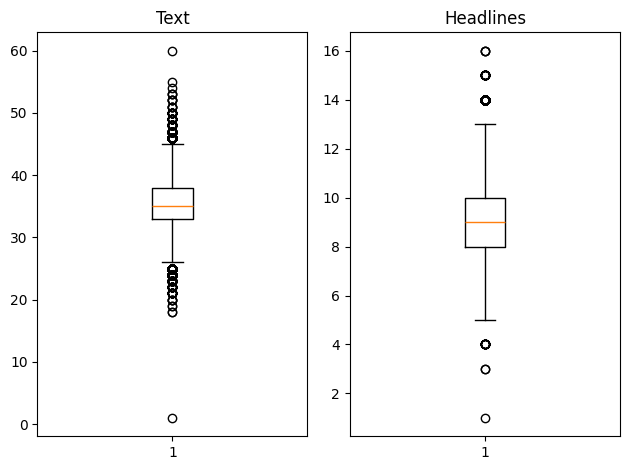

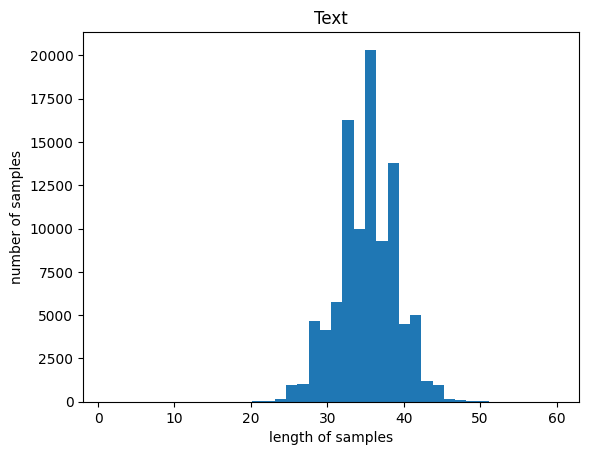

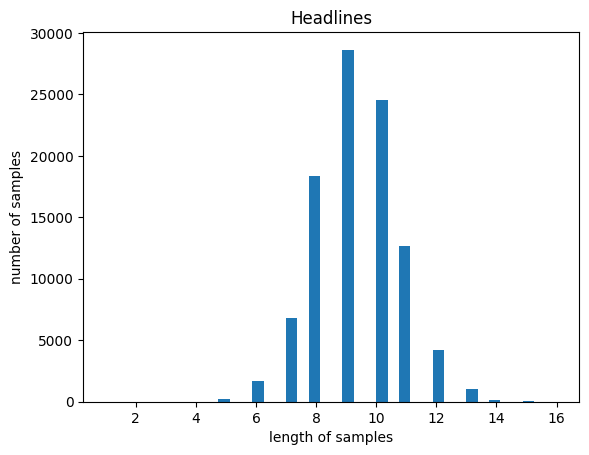

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

text_len = [len(s.split()) for s in data['Text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {:.2f}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {:.2f}'.format(np.mean(headlines_len)))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('Text')

plt.subplot(1, 2, 2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

# Histogram - Text
plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# Histogram - Headlines
plt.title('Headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

✅text_max_len은 평균 길이보다 여유 있는 **50**으로 설정해 정보 손실 없이 효율적인 학습이 가능하며, headlines_max_len은 평균 9.3에 근접한 **12**로 설정 -> <br> 핵심 요약 정보가 잘리지 않도록 하면서도 디코더의 패딩 부담을 최소화할 수 있음<br>

In [ ]:
text_max_len = 50
headlines_max_len = 12
print('완료')

완료


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('완료')

완료


In [ ]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


 👍**거의 모든 샘플을 커버하고 있음**

In [ ]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len) &
            data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print("제거 후 남은 샘플 수:", len(data))

제거 후 남은 샘플 수: 97169


### **시작 토큰과 종료 토큰 추가하기**

In [ ]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-28-233aeaad22b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-28-233aeaad22b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [ ]:
# 문자열 데이터를 넘파이 배열 형태로 준비
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('완료')

완료


**훈련 데이터와 테스트 데이터를 분리**

In [ ]:
# 데이터 셋 섞기 위한 인덱스 배열 생성 및 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[90183 81810 92821 ... 52238 39987   246]


In [ ]:
# 무작위로 섞은 인덱스를 이용해 입력과 출력 데이터를 동일한 순서로 셔플
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('완료')

완료


In [ ]:
# 전체 데이터의 20%를 검증 데이터로 사용하기 위한 샘플 수 계산
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19433


In [ ]:
# 훈련/테스트 데이터를 8:2 비율로 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


###**단어 집합(vocabulary) 만들기 및 정수 인코딩**

In [ ]:
# 훈련용 encoder 입력 데이터를 기반으로 단어 집합을 생성하는 토크나이저 정의 및 학습
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('완료')

완료


In [ ]:
# 희귀 단어의 통계 파악 (threshold 미만 등장 단어의 개수, 비율 등 계산)
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69339
등장 빈도가 6번 이하인 희귀 단어의 수: 47223
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22116
단어 집합에서 희귀 단어의 비율: 68.10452991822784
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4956623435435636


✅ 이 수치가 의미하는 바 <br>
	•	희귀 단어가 전체 단어 집합의 68%를 차지하지만,<br>
**등장 빈도는 고작 3.5%**밖에 안됨.<br>
	•	➤ 따라서, 희귀 단어를 제거해도 전체 정보 손실이 거의 없음 👌

In [ ]:
# 단어 집합 크기 (희귀 단어 제외 + padding 포함)
src_vocab = total_cnt - rare_cnt + 1

# 토크나이저 정의 및 재학습
# 등장 빈도가 threshold 미만인 희귀 단어들을 제외하고, 지정된 단어 집합 크기만큼 학습
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성

정확도를 높이고  의미 정보 손실을 줄이기 위헤 데이터 기반 자동 조정하여 등장 빈도 기반으로 희귀 단어 제외함.<br>
**src_vocab = total_cnt - rare_cnt + 1  # +1은 padding(0번) 토큰 포함**

In [ ]:
# 텍스트 데이터를 토크나이저를 이용해 정수 시퀀스로 변환 (단어 -> 인덱스)
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[41, 65, 1175, 834, 39, 878, 4036, 298, 12, 41, 3, 41, 115, 160, 317, 75, 1, 43, 236, 1175, 834, 185, 1718, 27, 99, 1657, 442, 41, 3552, 834, 834, 29, 15275, 41], [9996, 825, 956, 1705, 567, 2, 734, 1547, 126, 23, 120, 39, 613, 366, 2130, 384, 507, 18317, 956, 1, 4687, 140, 551, 507, 55, 481, 10934, 10440, 3050, 3796, 17, 1904, 27, 4], [364, 387, 59, 93, 3528, 1663, 1433, 3171, 2358, 2230, 416, 670, 439, 2230, 1170, 226, 89, 1831, 1202, 2487, 558, 1167, 371, 2349, 262, 3399, 5801, 1132, 35, 61, 5263, 6587, 1170, 7926, 2230, 112]]


In [ ]:
tar_tokenizer = Tokenizer()  # 디코더 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train)  # 디코더 입력 시퀀스로부터 단어 집합 생성
print('완료')

완료


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨.<br>


In [ ]:
# 디코더용 단어 집합에서 희귀 단어 비율 및 빈도 분석
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29968
등장 빈도가 5번 이하인 희귀 단어의 수: 19631
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10337
단어 집합에서 희귀 단어의 비율: 65.50654030966363
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.72553896972633


In [ ]:
# 디코더 단어 집합 크기 설정 (전체 단어 수 - 희귀 단어 수 + pad 토큰 포함)
tar_vocab = total_cnt - rare_cnt + 1

# 디코더 입력(decoder_input)과 출력(decoder_target)을 합쳐서 단어 집합 생성
# (fit_on_texts를 두 번 하면 덮어쓰이므로, 반드시 한 번에 합쳐서 학습)
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train + decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환 (텍스트 → 단어 인덱스 시퀀스)
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 변환 결과 샘플 출력 (정상적으로 인덱스로 변환되었는지 확인)
print('input')
print('input ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
input  [[1, 127, 383, 102, 1525, 1313, 9, 497, 565, 2174], [1, 271, 25, 20, 12, 1335, 1792, 70, 890, 750], [1, 1246, 370, 1497, 277, 11, 4550, 1585, 4, 3248], [1, 21, 42, 3887, 3, 20, 635, 3001, 999, 5, 165], [1, 95, 1446, 29, 58, 5695, 39, 667]]
target
decoder  [[127, 383, 102, 1525, 1313, 9, 497, 565, 2174, 2], [271, 25, 20, 12, 1335, 1792, 70, 890, 750, 2], [1246, 370, 1497, 277, 11, 4550, 1585, 4, 3248, 2], [21, 42, 3887, 3, 20, 635, 3001, 999, 5, 165, 2], [95, 1446, 29, 58, 5695, 39, 667, 2]]


	•	1 → 'sostoken'의 인덱스
	•	2 → 'eostoken'의 인덱스
✅ 입력은 시작을, 출력은 종료를 알려주는 구조

In [ ]:
# 1. 길이가 1인 요약문(즉, 'sostoken' 또는 'eostoken'만 존재하는 샘플)의 인덱스를 수집
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

# 확인: 삭제 대상이 되는 훈련/테스트 샘플 개수 출력
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 2. 훈련 데이터에서 해당 인덱스를 제외한 샘플만 남김 (의미 없는 샘플 제거)
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# 3. 테스트 데이터에서도 동일한 방식으로 제거
encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

# 최종 확인: 제거 후 데이터 개수 출력
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19432
테스트 레이블의 개수 : 19432


	decoder_input / decoder_target의 길이가 1인 샘플은 의미 없는 샘플이므로 반드시 제거해야 함.
그러나 	희귀 단어 제거 후에도 요약문에서 단어가 모두 사라지는 샘플이 없었음<br>
즉, 모든 샘플은 sostoken 또는 eostoken 이외에도 최소 1개 이상의 유효 단어가 남아 있어서 그대로 학습에 사용

**패딩하기**

그 전에...<br>
	•	data['Text'] : 대문자 T 사용 <br>
	•	data['headlines'] : 소문자 사용
  -> 일괄 소문자 처리하기 !

In [ ]:
# 'Text' 컬럼명만 소문자로 변경
data.rename(columns={'Text': 'text'}, inplace=True)

# 확인
print(data.columns)

Index(['headlines', 'text', 'text', 'decoder_input', 'decoder_target'], dtype='object')


⚠️❗️❗️❗️'text'가 중복...전처리 한 걸 찾아내 원본 데터는 제거해야함

In [ ]:
print(data['text'].head())
print(data['text'].duplicated().sum())  # 값 중복 확인

                                                text  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   
3  With Aegon Life iTerm Insurance plan, customer...   
5  Pakistani singer Rahat Fateh Ali Khan has deni...   

                                                text  
0  saurav kant alumnus upgrad iiit pg program mac...  
1  kunal shah credit card bill payment platform c...  
2  new zealand defeated india wickets fourth odi ...  
3  aegon life iterm insurance plan customers enjo...  
5  pakistani singer rahat fateh ali khan denied r...  
0


In [ ]:
# 첫 번째 'text' 컬럼(원본 텍스트) 제거하고, 전처리된 것만 유지
data = data.drop(columns=data.columns[0])  # 첫 번째 text 컬럼 제거

# 컬럼명 재정의: 두 번째 text 컬럼을 'text'로 재지정 (사실 이름은 이미 'text'지만 명확하게 재정의)
data.columns = ['headlines', 'text', 'decoder_input', 'decoder_target']

# 결과 확인
print(data.columns)
print(data.head())

Index(['headlines', 'text', 'decoder_input', 'decoder_target'], dtype='object')
                                           headlines  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   
3  With Aegon Life iTerm Insurance plan, customer...   
5  Pakistani singer Rahat Fateh Ali Khan has deni...   

                                                text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
1  kunal shah credit card bill payment platform c...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
5  pakistani singer rahat fateh ali khan denied r...   

                                       decoder_input  \
0  sostoken upgrad learner switches to career in ...   
1  sostoken delhi techie wins free food from swig...   
2  sostoken new zealand end rohit sharma led indi...   
3  sostoken aegon life

**드디어 패딩 !!! 😄**

In [ ]:
# 정수 시퀀스 데이터를 최대 길이에 맞춰 후행 패딩(post-padding) 수행
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 시퀀스 데이터 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

print('완료')

완료


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

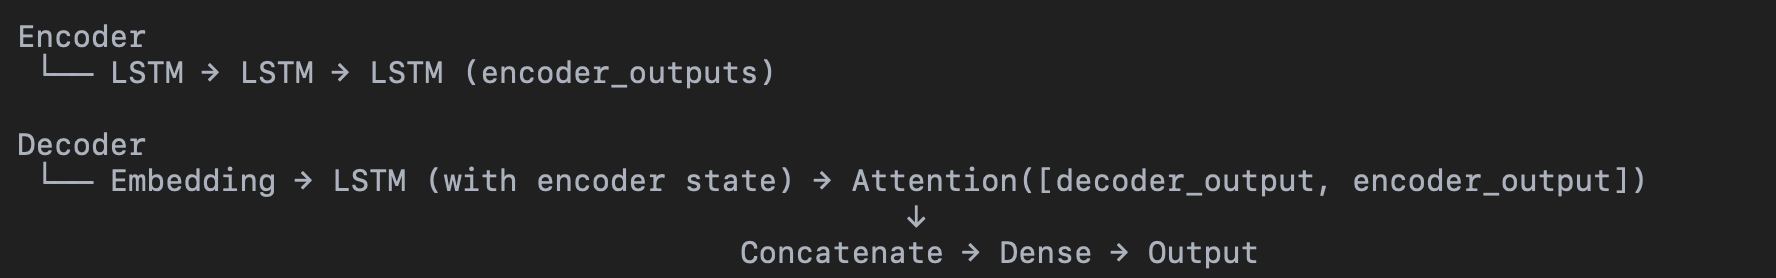

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention
from tensorflow.keras.models import Model

# 디코더 입력 정의
decoder_inputs = Input(shape=(None,))

# 디코더 임베딩
dec_emb_layer = Embedding(input_dim=tar_vocab, output_dim=128)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더 LSTM (단층 구조)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 메커니즘
attention = Attention()
attention_output = attention([decoder_outputs, encoder_outputs])  # query=decoder, value=encoder

# 어텐션 출력과 디코더 출력 결합
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# 출력층
decoder_dense = Dense(tar_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# 최종 모델
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 요약 출력
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  2,830,976 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,323,264 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 256) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  5,303,394 │ concatenate[0][0] │
│                     │ 10338)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,296,738 (43.09 MB)

 Trainable params: 11,296,738 (43.09 MB)

 Non-trainable params: 0 (0.00 B)

✅ 왜 디코더를 단층으로 구성하는가? <br>
	1.	어텐션 메커니즘이 인코더 전체 출력을 직접 활용하기 때문에, 디코더가 모든 정보를 깊게 쌓지 않아도 필요한 문맥을 다이렉트로 받아올 수 있음!<br>
	2.	디코더를 과하게 깊게 만들면 오히려 학습이 어려워지고 과적합 위험도 증가하기 때문에, 1~2층 정도가 가장 안정적인 구성으로 자주 사용!<br>

### **모댈 훈련**

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=50
)

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 258ms/step - loss: 6.3316 - val_loss: 5.5857
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 279ms/step - loss: 5.6274 - val_loss: 5.5442
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.5617 - val_loss: 5.4624
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - loss: 5.4793 - val_loss: 5.4054
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - loss: 5.4272 - val_loss: 5.3712
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.3856 - val_loss: 5.3384
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.3450 - val_loss: 5.3120
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.3125 - val_loss: 5.2716
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.2708 - val_loss: 5.1916
Epoch 10/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.1677 - val_loss: 5.1098
Epoch 11/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - loss: 5.0893 - val_loss: 5.0309
Epoch 12/50
304/304

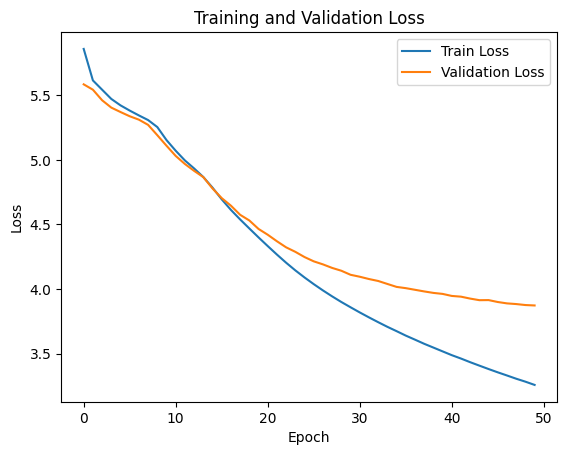

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### **훈련된 모델을 이제 실제 사용 가능하게 인코더와 디코더로 분리하기**

In [ ]:
# 원문 텍스트 인덱스를 다시 단어로 변환하는 딕셔너리 (정수 → 단어)
src_index_to_word = src_tokenizer.index_word

# 요약문 텍스트를 정수로 변환하는 딕셔너리 (단어 → 정수)
tar_word_to_index = tar_tokenizer.word_index

# 요약문 텍스트 인덱스를 다시 단어로 변환하는 딕셔너리 (정수 → 단어)
tar_index_to_word = tar_tokenizer.index_word

# 인퍼런스(추론) 단계에서 사용할 단어 인덱스 매핑 준비 완료
print('완료')

완료


In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 및 소프트맥스 레이어는 훈련 시 정의한 이름으로 통일하는 것이 중요함 -> 변수명 그대로 가져오기 ❗️❗️


# 1. 인퍼런스용 입력 정의
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

# 2. 디코더 입력 정의
decoder_inputs = Input(shape=(None,))
dec_emb2 = dec_emb_layer(decoder_inputs)  # 훈련 시 사용한 임베딩 레이어 재사용

# 3. 디코더 LSTM
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# 4. 어텐션 적용 (훈련 시 정의한 'attention' 객체 재사용)
attn_out_inf = attention([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1)([decoder_outputs2, attn_out_inf])

# 5. 소프트맥스 출력층 (훈련 시 사용한 Dense 레이어 재사용)
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# 6. 디코더 인퍼런스 모델 정의
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)

In [ ]:
import numpy as np

# 디코딩 함수: 인퍼런스 단계에서 요약을 생성함
def decode_sequence(input_seq):
    # 인코더 모델로부터 인코더 출력 및 최종 상태값들을 얻음
    encoder_outs, state_h, state_c = encoder_model.predict(input_seq)

    # 디코더 입력의 시작은 항상 <sostoken>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 모델로부터 다음 단어 예측
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outs, state_h, state_c]
        )

        # 예측된 단어 중 확률이 가장 높은 단어를 선택
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word.get(sampled_token_index, '')

        # 종료 토큰이 아니라면 결과에 추가
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eostoken> 이거나 최대 길이 도달 시
        if (sampled_token == 'eostoken') or (len(decoded_sentence.split()) >= (headlines_max_len - 1)):
            stop_condition = True

        # 다음 입력 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        state_h, state_c = h, c

    return decoded_sentence.strip()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i!=0 and i!=tar_word_to_index['sostoken'] and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
# 최종 확인용 코드 (50번째부터 99번째 샘플까지 예측)
for i in range(50, 100):
    print(f"샘플 번호: {i}")
    print("원문       :", seq2text(encoder_input_test[i]))
    print("실제 요약  :", seq2summary(decoder_target_test[i]))
    print("예측 요약  :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("-" * 80)

샘플 번호: 50
원문       : ceo encrypted messaging app telegram pavel said platform blocked channels october terrorist links violence promotion violence form banned added telegram faced criticism past claims terrorists criminals used encrypted communication 
실제 요약  : terrorist channels blocked in one month telegram ceo 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
예측 요약  : amazon to be fired as indian workers not anti terror
--------------------------------------------------------------------------------
샘플 번호: 51
원문       : boko haram militants wednesday released nigerian schoolgirls k

###**성능 피드백:<br>**
⚠️ 부족한 점 <br>
	•	**사실과 다른 내용 생성 (Hallucination):**<br>
  예측 요약이 전혀 없는 사건을 상상해냄 (예: “amazon fires…” / “kohli is not…”)<br>
	•	**개체명 대체 오류: 유명 인물, 장소, 사건 등의 매핑이 엉뚱함**<br>
	•	**불명확하거나 의미 없는 문장도 존재**

### **모델 저장**

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 저장 경로 설정
model_path = '/content/drive/MyDrive/summarization_model/final_summarization_model.h5'
src_tokenizer_path = '/content/drive/MyDrive/summarization_model/src_tokenizer.pkl'
tar_tokenizer_path = '/content/drive/MyDrive/summarization_model/tar_tokenizer.pkl'

In [ ]:
model.save('final_summarization_model.h5')

In [ ]:
# 폴더가 없으면 먼저 생성
import os
os.makedirs('/content/drive/MyDrive/summarization_model', exist_ok=True)

# 모델 저장
model.save(model_path)

# 토크나이저 저장
import pickle
with open(src_tokenizer_path, 'wb') as f:
    pickle.dump(src_tokenizer, f)
with open(tar_tokenizer_path, 'wb') as f:
    pickle.dump(tar_tokenizer, f)

print("✅ 모델과 토크나이저가 Google Drive에 저장되었습니다!")

✅ 모델과 토크나이저가 Google Drive에 저장되었습니다!


## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = '''
SEOUL, April 10 (Yonhap) -- South Korean stocks rallied 6.6 percent Thursday as the U.S. administration's temporary pause of reciprocal tariffs on South Korea improved market sentiment. The Korean won was trading sharply higher against the U.S. dollar.

The benchmark Korea Composite Stock Price Index (KOSPI) soared 151.36 points, or 6.6 percent, to close at 2,445.06, sharply rebounding from the 17-month low the previous day.

Shortly after the stock market opened, the bourse operator issued a sidecar order at 9:06 a.m., halting program purchasing for five minutes, after the KOSPI 200 futures soared 5 percent for more than one minute.

Trade volume was a bit heavy at 661 million shares worth 10.9 trillion won (US$7.5 billion), with winners far outperforming losers 873 to 47.

Foreigners and institutions purchased local shares worth 324.4 billion won and 676.2 billion won, respectively, while retail investors dumped a combined 1.07 trillion won.

Overnight, Wall Street posted one of the best days since the global financial crisis in 2008, with the S&P 500 surging 9.5 percent, the Dow Jones Industrial Average soaring 7.87 percent and the tech-heavy Nasdaq composite skyrocketing 12.16 percent.

The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.

He said the decision was made considering they have reached out to U.S. trade officials for negotiations and have not retaliated against the reciprocal tariffs.

Meanwhile, Trump increased duties on China to 125 percent following Beijing's announcement of a plan to raise tariffs on U.S. goods to 84 percent in a retaliatory move.

"Concerns turned to relief after the Trump announced a 90-day pause of reciprocal tariffs for countries other than China," Lee Kyoung-min, an analyst at Daishin Securities, said.

"Shares related to semiconductor, defense, electricity and mobile phone components, in particular, led the KOSPI's sharp rebound," he added.
'''

In [ ]:
print(text[:1500])


SEOUL, April 10 (Yonhap) -- South Korean stocks rallied 6.6 percent Thursday as the U.S. administration's temporary pause of reciprocal tariffs on South Korea improved market sentiment. The Korean won was trading sharply higher against the U.S. dollar.

The benchmark Korea Composite Stock Price Index (KOSPI) soared 151.36 points, or 6.6 percent, to close at 2,445.06, sharply rebounding from the 17-month low the previous day.

Shortly after the stock market opened, the bourse operator issued a sidecar order at 9:06 a.m., halting program purchasing for five minutes, after the KOSPI 200 futures soared 5 percent for more than one minute.

Trade volume was a bit heavy at 661 million shares worth 10.9 trillion won (US$7.5 billion), with winners far outperforming losers 873 to 47.

Foreigners and institutions purchased local shares worth 324.4 billion won and 676.2 billion won, respectively, while retail investors dumped a combined 1.07 trillion won.

Overnight, Wall Street posted one of the

In [ ]:
# 본문 텍스트에서 중요 문장들을 상위 15% 비율로 추출해서 요약
# summarize 함수는 gensim.summarization 모듈의 함수로, extractive summarization을 수행함
# ratio=0.15는 전체 문장 중 상위 15% 정도의 중요한 문장만 반환하라는 의미
print('Summary:')
print(summarize(text, ratio=0.15, split=True))

Summary:
['The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.']


In [ ]:
# 본문 텍스트에서 가장 중요한 내용 50단어 이내로 요약
# summarize 함수는 gensim.summarization에서 제공되며, extractive summarization을 수행함
# words=50은 요약문의 총 단어 수가 50개를 넘지 않도록 제한하라는 의미
print('Summary:')
print(summarize(text, words=50))

Summary:
SEOUL, April 10 (Yonhap) -- South Korean stocks rallied 6.6 percent Thursday as the U.S. administration's temporary pause of reciprocal tariffs on South Korea improved market sentiment.
The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.


왜인지..위에꺼 보다 더 잘하는 느낌...😂

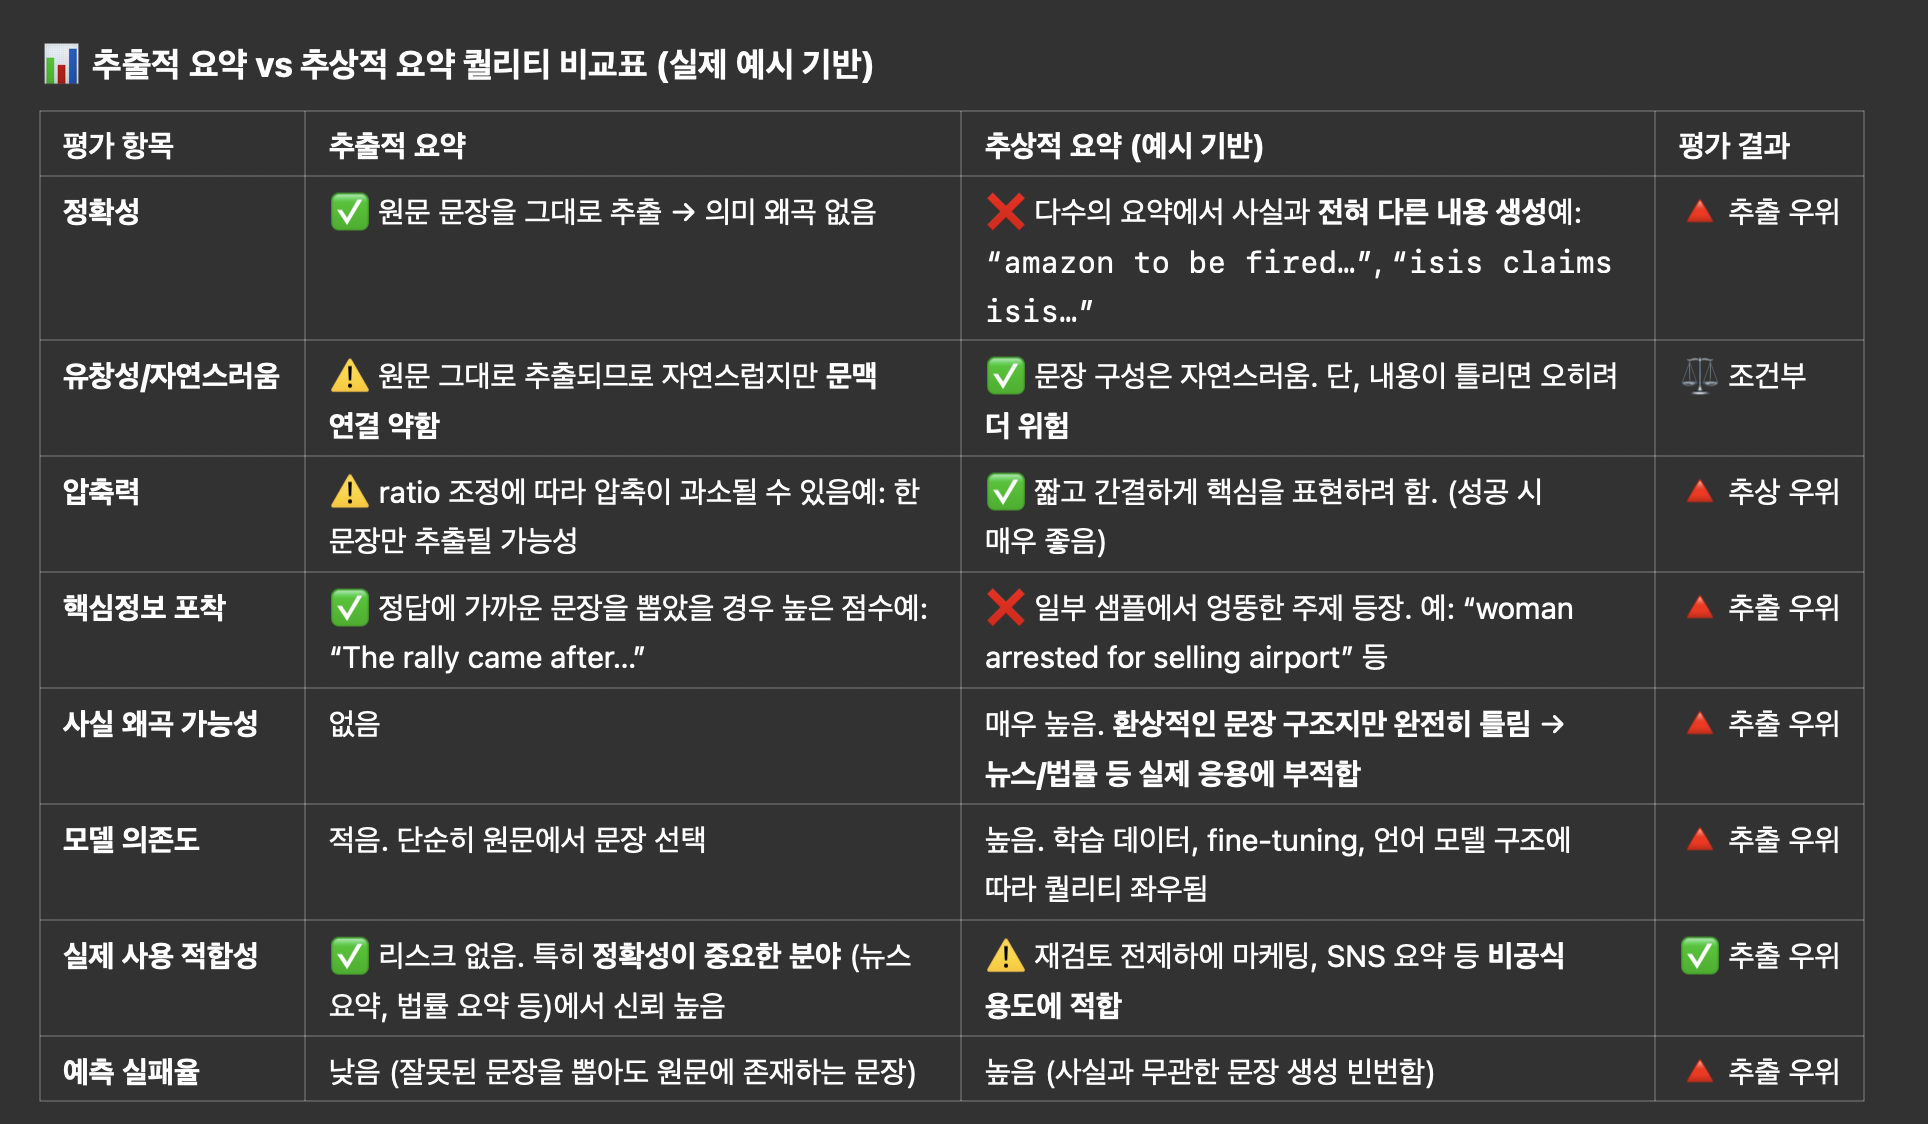

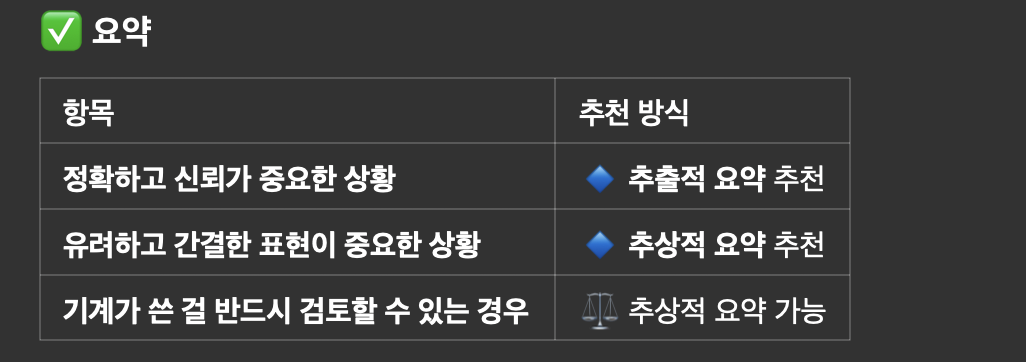

📌 민유경 회고

✅ **오늘의 경험**  <br>
	•	오늘은 딥러닝 모델을 사용하여 텍스트 요약을 수행하는 과정을 경험해보았다. <br>
  • 원문데이터를 정수시퀀스로 변환하고, 이를 바탕으로 실제 요약문과 모델이 예측한 요약문을 비교하는 작업을 했고 그 과정에서 요약 성능을 평가하고 추출적 요약기법은 Summa 까지도 활용해보았다.

🧠 **느낀 점**  <br>
	•	추상적 요약과 추출적 요약의 차이를 살펴볼 수 있었다. <br>
	•	딥러닝 모델의 요약 성능 평가에 있어 실제 결과와 예측결과 비교하는 것이 중요하는 점을 느꼈다. <br>

🔄 **앞으로의 방향** <br>
	•	코드를 짜면서 플로우를 유지하고 어느부분에서 오류가 났는지 빨리 파악할것 <br>
	•	과정의 반복학습을 통해 능수능란하게 코드를 짤 수 있도록 하고싶다. <br>

📌 허재은 회고

✅ **오늘의 경험**  <br>
	•	처음으로 딥러닝 기반 자연어 처리 실습을 진행했다. <br>
	•	생각보다 과정이 복잡했고, 모델의 요약 결과 퀄리티도 기대보다 낮았다. <br>

🧠 **느낀 점**  <br>
	•	실습을 따라가면서 이론과 코드가 잘 연결되지 않아 혼란스러웠다. <br>
	•	내가 얼마나 개념이 부족한 상태에서 실습에 들어갔는지 깨닫게 되었다. <br>

🔄 **앞으로의 방향** <br>
	•	전체적인 순서와 개념 흐름을 다시 정리해볼 계획이다. <br>
	•	실습보다 이론을 먼저 정리하고, 이후 다시 실습을 재구성해볼 것. <br>